# Deep Learning Lab: CNN with Data Augmentation and Dropout (MNIST)

**Target audience:** 2nd Year B.Tech  
**Goal:** Train a CNN on MNIST and understand:
- Why CNNs are better than MLPs for images
- Data Augmentation (to reduce overfitting)
- Dropout (regularization)
- Train vs Validation curves (overfitting detection)

> Run cells **top to bottom**. This notebook trains **two models**:
1. CNN **without** Dropout (baseline)
2. CNN **with** Dropout (regularized)

---


## 1) Imports & Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0


## 2) Load MNIST Dataset

MNIST contains 28×28 grayscale images of handwritten digits (0–9).

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


### Normalize + Add Channel Dimension

CNN expects input shape: **(height, width, channels)**.
MNIST is grayscale → channels = 1.

In [3]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension: (N, 28, 28) -> (N, 28, 28, 1)
x_train = x_train[..., tf.newaxis]
x_test  = x_test[..., tf.newaxis]

print("After preprocessing:")
print("Train:", x_train.shape)
print("Test :", x_test.shape)

After preprocessing:
Train: (60000, 28, 28, 1)
Test : (10000, 28, 28, 1)


### Visualize a Few Samples

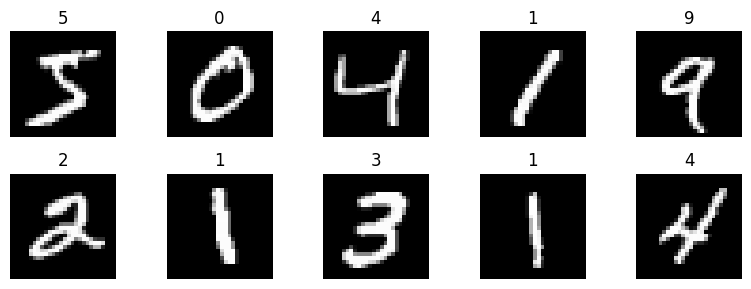

In [4]:
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(int(y_train[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3) Data Augmentation

**Why?** It increases the diversity of training images by applying random transformations.
This helps the model generalize better and reduces overfitting.

We will use:
- RandomRotation
- RandomZoom
- RandomTranslation


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.08, 0.08),
], name="data_augmentation")

data_augmentation

<Sequential name=data_augmentation, built=False>

### Preview Augmented Images (same image, different versions)

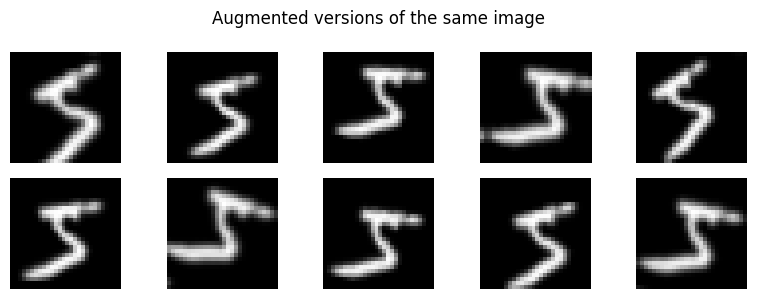

In [6]:
sample = x_train[0:1]  # one image

plt.figure(figsize=(8,3))
for i in range(10):
    augmented = data_augmentation(sample, training=True)
    plt.subplot(2,5,i+1)
    plt.imshow(augmented[0].numpy().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Augmented versions of the same image")
plt.tight_layout()
plt.show()

## 4) Model A: CNN (Baseline) — **No Dropout**

Architecture:
- Data Augmentation
- Conv(32) + MaxPool
- Conv(64) + MaxPool
- Flatten
- Dense(128)
- Dense(10, softmax)


In [7]:
def build_cnn_baseline():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        data_augmentation,
        layers.Conv2D(32, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ], name="CNN_Baseline_NoDropout")
    return model

model_a = build_cnn_baseline()
model_a.summary()

Model: "CNN_Baseline_NoDropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Compile & Train Model A

In [ ]:
model_a.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_a = model_a.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/5


## 5) Plot Curves for Model A

Look for overfitting signs:
- Training accuracy keeps increasing
- Validation accuracy stops improving / decreases


In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(7,4))
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " (Loss)")
    plt.legend()
    plt.show()

plot_history(history_a, "Model A: CNN Baseline (No Dropout)")

## 6) Model B: CNN with Dropout (Regularization)

**Dropout** randomly turns off some neurons during training:
- reduces memorization (overfitting)
- improves generalization

We add dropout:
- after pooling layers (0.25)
- before final classification (0.5)


In [ ]:
def build_cnn_with_dropout():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        data_augmentation,
        layers.Conv2D(32, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.50),
        layers.Dense(10, activation="softmax")
    ], name="CNN_WithDropout")
    return model

model_b = build_cnn_with_dropout()
model_b.summary()

### Compile & Train Model B

In [ ]:
model_b.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_b = model_b.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_test, y_test),
    verbose=1
)

## 7) Plot Curves for Model B

In [ ]:
plot_history(history_b, "Model B: CNN + Dropout")

## 8) Compare Final Test Accuracy

We evaluate both models on the test set.


In [ ]:
test_loss_a, test_acc_a = model_a.evaluate(x_test, y_test, verbose=0)
test_loss_b, test_acc_b = model_b.evaluate(x_test, y_test, verbose=0)

print("Model A (No Dropout)  - Test Accuracy:", round(test_acc_a, 4), " Test Loss:", round(test_loss_a, 4))
print("Model B (With Dropout) - Test Accuracy:", round(test_acc_b, 4), " Test Loss:", round(test_loss_b, 4))

## 9) Predict on a Few Test Images

We show predicted labels vs actual labels.


In [ ]:
def show_predictions(model, x, y, n=10):
    preds = model.predict(x[:n], verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(8,3))
    for i in range(n):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i].squeeze(), cmap="gray")
        plt.title(f"P:{pred_labels[i]} / T:{y[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Predictions using Model B (Dropout):")
show_predictions(model_b, x_test, y_test, n=10)

## 10) Student Exercises (Lab Tasks)

1. Increase epochs to 10 and compare overfitting behavior.  
2. Change dropout rates (0.1, 0.3, 0.7) and observe performance.  
3. Remove data augmentation and check whether overfitting increases.  
4. Try CIFAR-10 dataset (harder): `tf.keras.datasets.cifar10`.  
5. Add Batch Normalization after convolution layers and compare.  


## 11) Quick Viva Questions

- Why is CNN better than MLP for images?  
- What does a convolution filter learn?  
- Why do we use MaxPooling?  
- What is overfitting? How do you detect it?  
- How does Data Augmentation help?  
- How does Dropout reduce overfitting?  
